### Import Essential Libraries

In [1]:
# import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Raw Data Ingestion

In [2]:
# load the dataset
computer_eq = pd.read_csv('data/computer_equipment.csv')
computer_hd = pd.read_csv('data/computer_hardware.csv')
computer_sf = pd.read_csv('data/computer_software.csv')
consumables = pd.read_csv('data/consumables.csv')
equipment = pd.read_csv('data/equipment.csv')
intdept_exp = pd.read_csv('data/interdepartment_expenditure.csv')
lowval_equipment = pd.read_csv('data/low_value_equipment.csv')
misc = pd.read_csv('data/miscellaneous.csv')

### Data Cleaning

In [3]:
# remove the last 2 rows (which are the total/summary of the expenses)
computer_eq = computer_eq.iloc[:-2, :]
computer_hd = computer_hd.iloc[:-2, :]
computer_sf = computer_sf.iloc[:-2, :]
consumables = consumables.iloc[:-2, :]
equipment = equipment.iloc[:-2, :]
intdept_exp = intdept_exp.iloc[:-2, :]
lowval_equipment = lowval_equipment.iloc[:-2, :]
misc = misc.iloc[:-2, :]

In [4]:
# subset the dataset with selected columns
selected_feats = ['Fiscal Year', 'Posting Date', 'Cost Element', 'Cost element name', 'Val/COArea Crcy', 'Name of offsetting account', 'Document Date']

computer_eq_subset = computer_hd[selected_feats]
computer_hd_subset = computer_hd[selected_feats]
computer_sf_subset = computer_sf[selected_feats]
consumables_subset = consumables[selected_feats]
equipment_subset = equipment[selected_feats]
intdept_exp_subset = intdept_exp[selected_feats]
lowval_equipment_subset = lowval_equipment[selected_feats]
misc_subset = misc[selected_feats]

In [5]:
# combine all subset of dataset (different expenses) into a single dataset
merged_df = pd.concat([computer_eq_subset,computer_hd_subset,computer_sf_subset,consumables_subset,equipment_subset,intdept_exp_subset,lowval_equipment_subset,misc_subset], axis=0)
merged_df.reset_index(drop=True, inplace=True)

# rename the column name
merged_df.columns = ['Fiscal_Year', 'Posting_Date', 'GL_Code', 'Category', 'Value', 'Vendor', 'Invoice_Date']
merged_df.head()

,Fiscal_Year,Posting_Date,GL_Code,Category,Value,Vendor,Invoice_Date
0,2019.0,27/8/2019,731401.0,Comp Hw-Pur(Exp Off),695.50,DELL GLOBAL B.V. (SINGAPORE BRANCH),25/7/2019
1,2019.0,27/8/2019,731401.0,Comp Hw-Pur(Exp Off),"1,016.50",DELL GLOBAL B.V. (SINGAPORE BRANCH),25/7/2019
2,2019.0,27/8/2019,731401.0,Comp Hw-Pur(Exp Off),738.30,DELL GLOBAL B.V. (SINGAPORE BRANCH),25/7/2019
3,2019.0,27/8/2019,731401.0,Comp Hw-Pur(Exp Off),214.00,DELL GLOBAL B.V. (SINGAPORE BRANCH),25/7/2019
4,2019.0,1/9/2019,731401.0,Comp Hw-Pur(Exp Off),35.00,TAN SHIH JEN,1/9/2019


In [6]:
# dictinary mapping to rename the Category for better understanding
category_mapping = {'Comp Hw-Pur(Exp Off)':'Computer Hardware',
                    'Comp Softw-Pur':'Computer Software',
                    'Expenditur-Interdept':'Interdepartment Expenditure',
                    'Equip-Pur (Exp Off)':'Low Value Equipment',
                    'Trg/Oth Misc':'Training & Miscellaneous'}

# data cleaning
merged_df['GL_Code'] = merged_df['GL_Code'].apply(lambda x: str(int(x)))
merged_df['Fiscal_Year'] = merged_df['Fiscal_Year'].apply(lambda x: int(x))
merged_df['Value'] = merged_df['Value'].apply(lambda x: float(x.replace(',','')))
merged_df['Posting_Date'] = pd.to_datetime(merged_df['Posting_Date'], dayfirst=True)
merged_df['Invoice_Date'] = pd.to_datetime(merged_df['Invoice_Date'], dayfirst=True)
merged_df['Category'] = merged_df['Category'].map(category_mapping).fillna(merged_df['Category'])

# display the first 5 rows after data cleaning
display(merged_df.head())

# export the cleaned dataset into csv file
merged_df.to_csv('data/startup.csv', index=False)

,Fiscal_Year,Posting_Date,GL_Code,Category,Value,Vendor,Invoice_Date
0,2019,2019-08-27,731401,Computer Hardware,695.5,DELL GLOBAL B.V. (SINGAPORE BRANCH),2019-07-25
1,2019,2019-08-27,731401,Computer Hardware,1016.5,DELL GLOBAL B.V. (SINGAPORE BRANCH),2019-07-25
2,2019,2019-08-27,731401,Computer Hardware,738.3,DELL GLOBAL B.V. (SINGAPORE BRANCH),2019-07-25
3,2019,2019-08-27,731401,Computer Hardware,214.0,DELL GLOBAL B.V. (SINGAPORE BRANCH),2019-07-25
4,2019,2019-09-01,731401,Computer Hardware,35.0,TAN SHIH JEN,2019-09-01


### Helper Function

In [7]:
# function to convert the dataset when load for usage
def process_loaded_data(data):
    import pandas as pd
    data['Posting_Date'] = pd.to_datetime(data['Posting_Date'], dayfirst=True)
    data['Invoice_Date'] = pd.to_datetime(data['Invoice_Date'], dayfirst=True)
    data['Invoice_Year'] = data['Invoice_Date'].dt.year
    data['Invoice_Month'] = data['Invoice_Date'].dt.month
    data['Invoice_Day'] = data['Invoice_Date'].dt.day
    return data

In [8]:
# function to preprocess the data for plotting heatmap
def preprocess_heatmap(data):
    import pandas as pd
    daily_total = data.groupby(['Invoice_Year','Invoice_Month','Invoice_Day'])['Value'].sum().reset_index()
    
    years = daily_total['Invoice_Year'].unique()
    months = daily_total['Invoice_Month'].unique()
    days = np.arange(1,32)

    index = pd.MultiIndex.from_product([years, months, days], names = ['Invoice_Year','Invoice_Month', 'Invoice_Day'])

    daily_total = daily_total.set_index(['Invoice_Year','Invoice_Month', 'Invoice_Day']).reindex(index, fill_value=0).reset_index()
    return daily_total

In [9]:
# function to plot heatmap
def plot_heatmap(data, year):
    import pandas as pd
    import plotly.graph_objects as go
    
    selected_data = data[data['Invoice_Year'] == year]
    pivot = selected_data.pivot('Invoice_Month', 'Invoice_Day', 'Value').fillna(0)

    # create the heatmap using Plotly Graph Objects
    fig = go.Figure(data=go.Heatmap(
        z=pivot.values,
        x=pivot.columns,
        y=pivot.index,
        colorscale='sunset_r',
        colorbar=dict(title='Value'),
        hovertemplate='Month: %{y}<br>Day: %{x}<br>Total Expense: S$ %{customdata:.2f}<extra></extra>',
        customdata=pivot.values
    ))

    # add border lines by drawing rectangles around each cell
    shapes = []
    for i, row in enumerate(pivot.index):
        for j, col in enumerate(pivot.columns):
            shapes.append(
                go.layout.Shape(
                    type="rect",
                    x0=col - 0.5, x1=col + 0.5,
                    y0=row - 0.5, y1=row + 0.5,
                    line=dict(color='grey', width=1)
                )
            )

    fig.update_layout(
        title=f'Total Invoice Amount per Month per Year ({year})',
        xaxis_title='Day',
        yaxis_title='Month',
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(1, 32)),
        ),
        yaxis=dict(
            tickmode='array',
            tickvals=pivot.index.tolist(),
            ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        ),
        shapes=shapes,
        height=500,
        width=1000,
        template='plotly_dark'
    )

    fig.show()

In [115]:
# function to plot treemap
def plot_treemap(data, year):
    import pandas as pd
    import plotly.graph_objects as go
    
    if year == 'All Years':
        df = data
        con = 'All Years'
    else:
        df = data[data['Invoice_Year'] == year]
        con = f'Year: {year}'
    
    fig = px.treemap(df, path=[px.Constant(con), 'Category'], values='Value', width=800, height=800)
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.update_traces(root_color='lightgrey')
    fig.update_layout(template='plotly_dark')
    fig.show()

In [178]:
# function to plot bubble chart
def plot_bubble(data, year):
    import plotly.express as px
    import pandas as pd
    
    # remove the negative value in the data
    df = data[data['Value'] > 0]

    # aggregate the data by summing the 'Value' for each 'Vendor' and 'Category' combination
    aggregated_data = df.query(f'Invoice_Year == {year}').groupby(['Vendor', 'Category']).agg({'Value': 'sum'}).reset_index()

    # create the bubble chart using the aggregated data
    fig = px.scatter(
        aggregated_data, 
        x='Vendor', 
        y='Category', 
        size='Value',  # column to determine the size of the bubbles
        color='Category', 
        size_max=60, 
        height=600,
        width=1200,
    )

    fig.update_layout(template='plotly_dark')
    fig.show()

In [212]:
# function to construct a dataframe for the expenses by vendors
def vendor_by_expenses(data, year):
    import pandas as pd
    expenses = np.round(data[data['Invoice_Year']==year].groupby('Vendor')['Value'].sum(),2).sort_values(ascending=False)
    vendor_breakdown = pd.DataFrame(expenses).reset_index()
    return vendor_breakdown

In [224]:
# function to get key metrics
def get_key_metrics(data, year):
    selected_data = data[data['Invoice_Year']==year]
    exp = selected_data['Value'].sum().round(2)
    total_order = selected_data.shape[0]

    exp_vendor = selected_data[selected_data['Value']==selected_data['Value'].max()]
    exp_vendor_name = exp_vendor['Vendor'].values[0]
    exp_value = exp_vendor['Value'].values[0]

    inv_processing_time = selected_data['Posting_Date'] - selected_data['Invoice_Date']
    avg_inv_processing_time = round(inv_processing_time.dt.days.mean(),2)
    longest_inv_processing_time = round(inv_processing_time.dt.days.max(),2)
    return [exp, total_order, exp_vendor_name, exp_value, avg_inv_processing_time, longest_inv_processing_time]

### Data Visualization

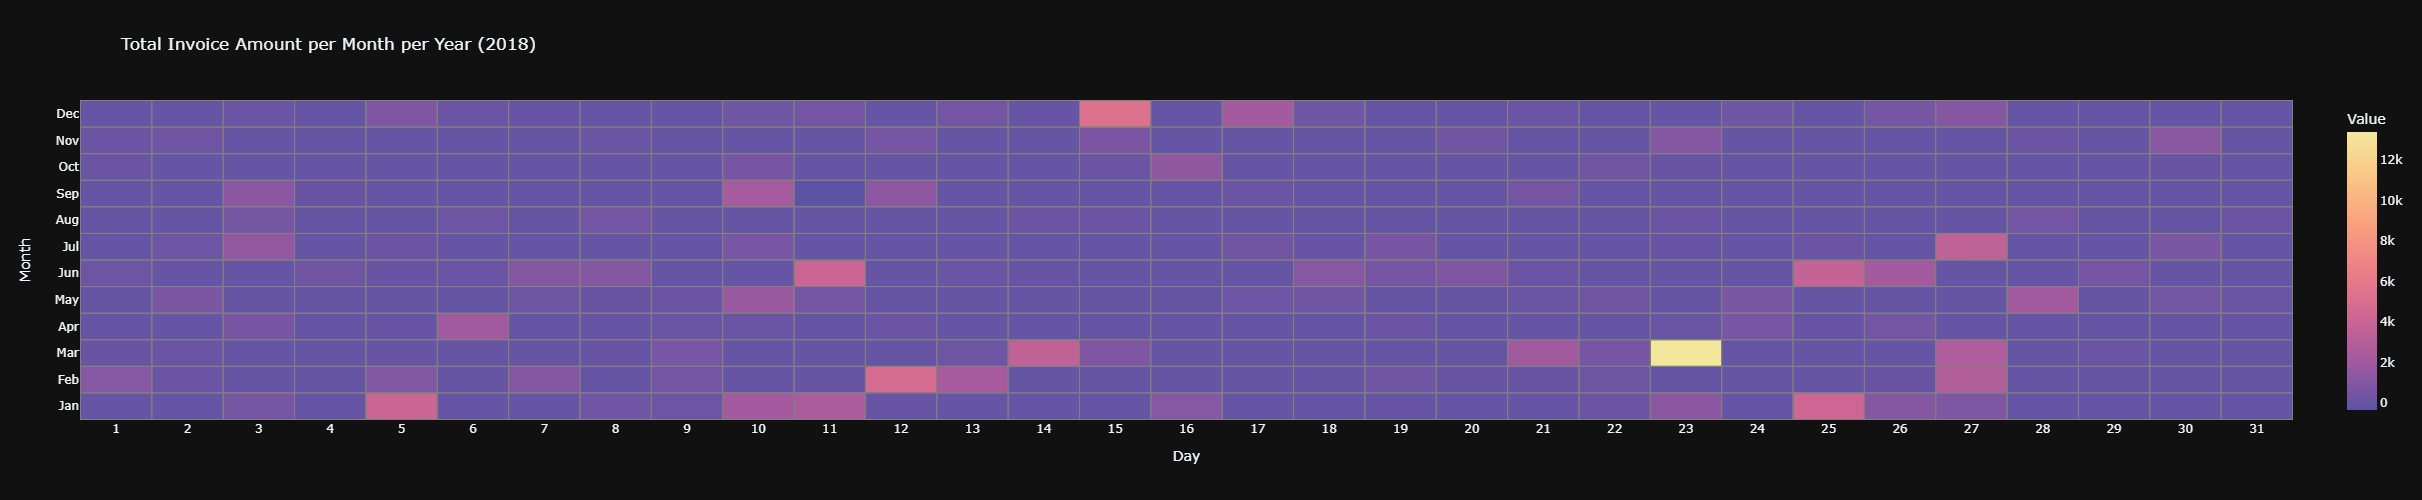

In [226]:
# heatmap --- analysis of expenses by day and month
df = pd.read_csv('data/startup.csv')
df = process_loaded_data(df)
df = preprocess_heatmap(df)
plot_heatmap(df, 2018)

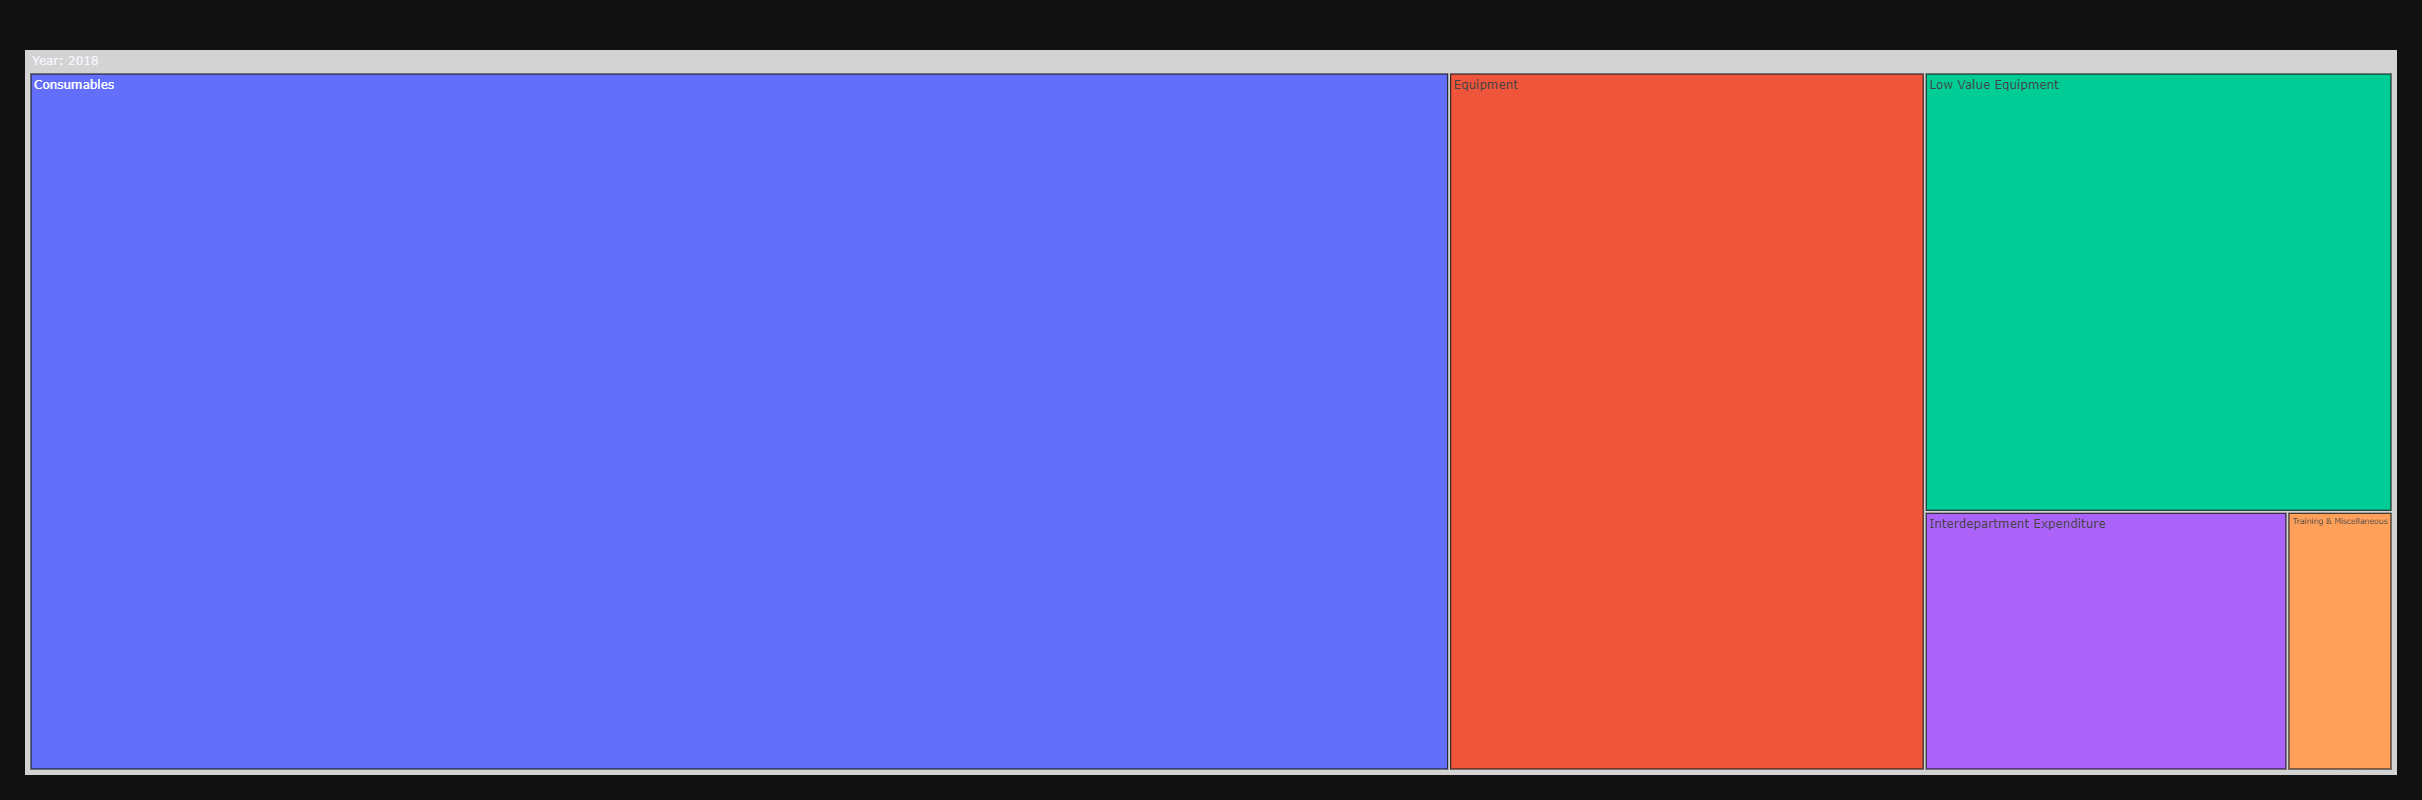

In [227]:
### treemap --- analysis of expenses by category
df = pd.read_csv('data/startup.csv')
df = process_loaded_data(df)
plot_treemap(df, 2018)

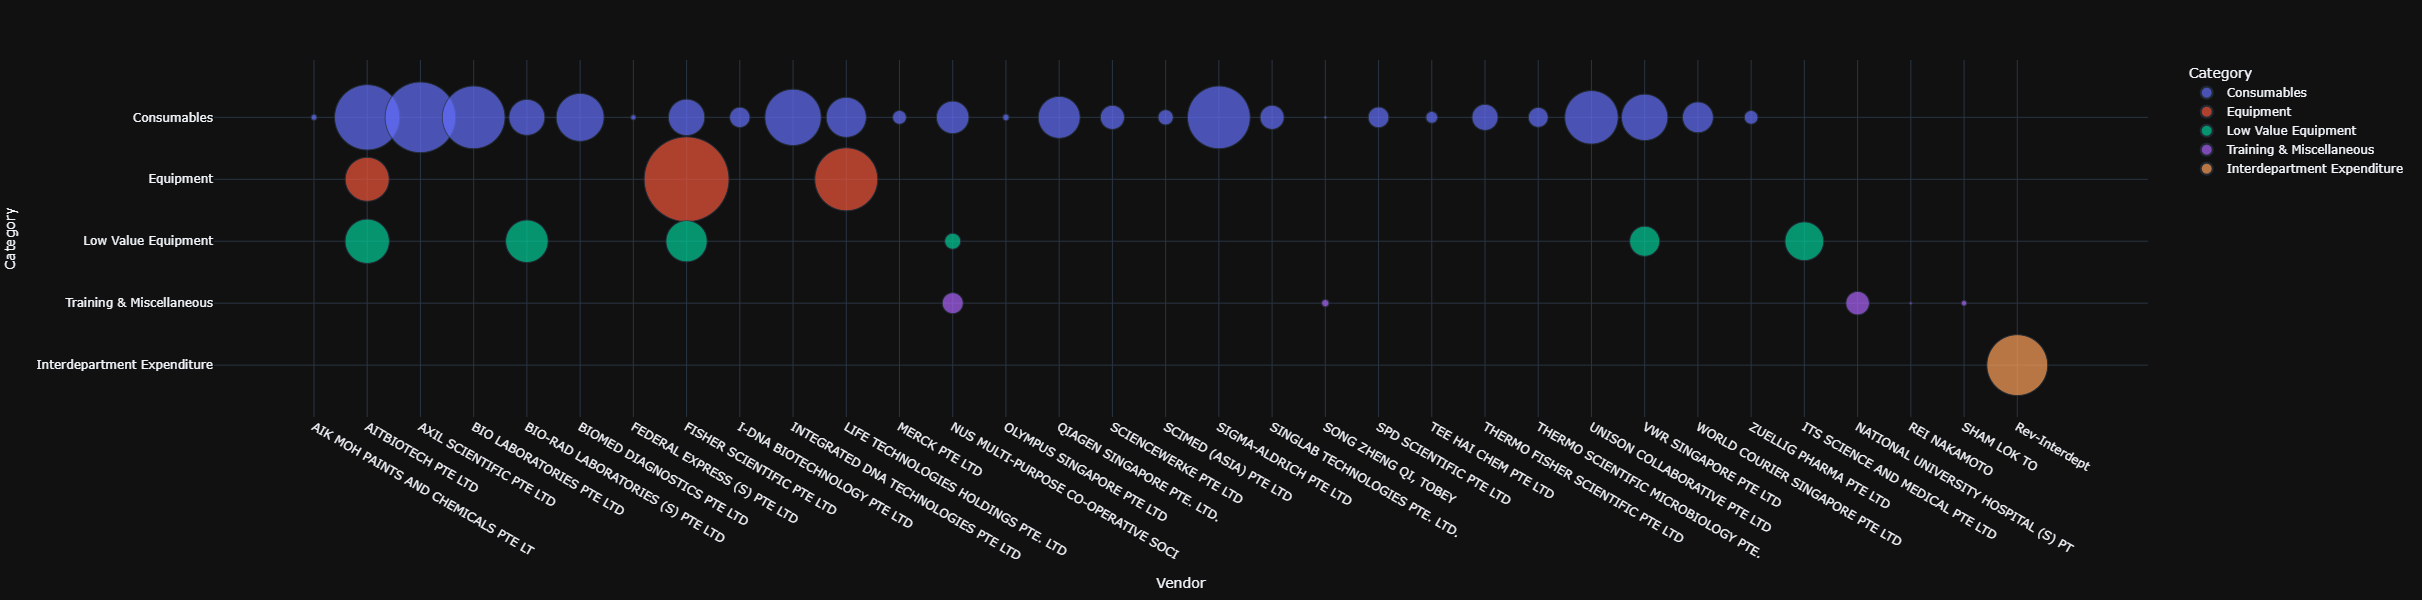

In [228]:
# bubble chart --- analysis of expenses by category and vendors
df = pd.read_csv('data/startup.csv')
df = process_loaded_data(df)
plot_bubble(df, 2018)

In [229]:
# table summary for the expenses on different vendors
df = pd.read_csv('data/startup.csv')
df = process_loaded_data(df)

vendor_by_expenses(df, 2018)

,Vendor,Value
0,FISHER SCIENTIFIC PTE LTD,18981.33
1,AITBIOTECH PTE LTD,15142.53
2,LIFE TECHNOLOGIES HOLDINGS PTE. LTD,10338.88
3,AXIL SCIENTIFIC PTE LTD,9272.62
4,BIO LABORATORIES PTE LTD,7303.83
5,SIGMA-ALDRICH PTE LTD,7299.65
6,Rev-Interdept,6879.95
7,INTEGRATED DNA TECHNOLOGIES PTE LTD,5885.00
8,BIO-RAD LABORATORIES (S) PTE LTD,5739.28
9,VWR SINGAPORE PTE LTD,5661.94


In [230]:
# key metrics
df = pd.read_csv('data/startup.csv')
df = process_loaded_data(df)

get_key_metrics(df, 2018)

[120903.35, 216, 'FISHER SCIENTIFIC PTE LTD', 11770.0, 31.5, 84]